In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/Google Colab/openpose')
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/Google Colab/openpose


In [ ]:
# import random
# import numpy as np
# data = np.ones((3,1,1,2))
# C, T, V, M = data.shape
# size = 4
# begin = random.randint(0, size-T)
# data_paded = np.zeros((C, size, V, M))
# data_paded[:, begin:begin + T, :, :] = data
# print(data_paded)
# print(data_paded.shape)

In [ ]:
import os
import random
from glob import glob
from typing import Tuple
from collections import OrderedDict

import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch import optim
from torch import nn, Tensor
import torch.utils.data as data
from sklearn.manifold import TSNE
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from feeder import tools 
from src.body import Body # openpose
from net.st_gcn import Model

In [ ]:
# stgcn = Model(in_channels=3,
#                 num_class=7,
#                 graph_args={'layout': 'openpose', 'strategy': 'spatial'},
#                 edge_importance_weighting=True)
# i = torch.load('0.pt')
# print(i.shape)
# o = stgcn(i)
# print(o.shape)
# print(stgcn.extract_feature(i)[0].shape)

torch.Size([40, 3, 30, 18, 1])
torch.Size([40, 7])
torch.Size([40, 7, 8, 18, 1])


In [ ]:
a  = np.load('0.npy')
print(a.shape)

(2, 3, 60, 18, 1)


In [ ]:
def create_skeleton_data(posenet_path, max_frame=60):
    body_estimation = Body(posenet_path)
    size = 256

    for label, dir_path in enumerate(glob('video_data/*')):
        all_skeletons = []

        for data_path in tqdm(glob(os.path.join(dir_path, '*.mp4'))):
            mv= cv2.VideoCapture(data_path)
            frame_count =int(mv.get(cv2.CAP_PROP_FRAME_COUNT))
            skeletons = []

            for frame_index in range(frame_count):
                if frame_index >= max_frame: break
                ch, frame = mv.read()
                
                if not ch: 
                    print('frame error')
                    continue

                candidate, subset = body_estimation(frame)
                skeleton = []

                for i in range(18):
                    x, y = 0, 0
                    index = int(subset[0][i])
                    if index != -1 and candidate[index][2] != 0:
                        x, y = candidate[index][0:2] / size - 0.5
                    confidence = candidate[index][2]
                    skeleton.append([x, y, confidence])

                skeletons.append(skeleton)

            skeletons = np.expand_dims(np.array(skeletons).transpose(2,0,1),3)
            skeletons = tools.auto_pading(skeletons, max_frame)
            all_skeletons.append(skeletons)
            cv2.destroyAllWindows()

        all_skeletons_numpy = np.array(all_skeletons)
        np.save(str(label)+'.npy', all_skeletons_numpy)
        print(all_skeletons_numpy.shape)
        print(label, ' finished')
# create_skeleton_data('./model/body_pose_model.pth')

In [ ]:
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [ ]:
def data_load():
    train_rate = 0.7
    train_data, val_data = [], []

    for label in range(7):
        skeleton = np.load(str(label)+'.npy')
        train_size = int(len(skeleton) * train_rate)

        for i, s in enumerate(skeleton):
            if i < train_size:
                train_data.append({'label': label, 'skeleton': s})
            else:
                val_data.append({'label': label, 'skeleton': s})

    print('train size ', len(train_data))
    print('val size ', len(val_data))

    return train_data, val_data

In [ ]:
class LoadDataset(data.Dataset):    
    def __init__(self, dataset_list, random_choose=False, random_move=False, window_size=60):
        self.dataset_list = dataset_list
        self.random_choose = random_choose
        self.random_move = random_move
        self.window_size = window_size
        
    def __len__(self):
        return len(self.dataset_list)

    def __getitem__(self, index):
        skeleton = self.dataset_list[index]['skeleton']

        if self.random_choose:
            skeleton = tools.random_choose(skeleton, self.window_size)
        if self.random_move:
            skeleton = tools.random_move(skeleton)

        label = torch.tensor(self.dataset_list[index]['label'])
        skeleton_tensor = torch.tensor(skeleton).float()

        return skeleton_tensor, label

In [ ]:
def make_dataloader():
    batch_size = 64
    
    train_data, val_data = data_load()

    train_dataset = LoadDataset(train_data, random_choose=True, random_move=True)
    val_dataset = LoadDataset(val_data, random_choose=False, random_move=False)

    train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
    val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=False)
    
    return {'train': train_dataloader, 'val': val_dataloader}

In [ ]:
def train(net, dataloader, criterion, optimizer, sheduler, epochs):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    print('train on ', device)

    net = net.to(device)
    if device == 'cuda:0':
        net = torch.nn.DataParallel(net) # make parallel
        torch.backends.cudnn.benchmark = True

    criterion = criterion.to(device)
    
    loss_dic = {'train': [], 'val': []}
    acc_dic = {'train': [], 'val': []}
    min_val_loss = -1.0

    for epoch in range(epochs):
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, epochs))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_acc = 0.0
            
            for skeletons, labels in tqdm(dataloader[phase]):
                skeletons = skeletons.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, features = net(skeletons)
                    features = nn.functional.normalize(features.mean(dim=[2, 3]))
                    corrects = sum(torch.argmax(outputs, dim=1) == labels).item()
                    
                    loss = criterion(*convert_label_to_similarity(features, labels))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_loss += loss.item() * skeletons.size(0)
                epoch_acc += corrects

            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            epoch_acc = epoch_acc / len(dataloader[phase].dataset)
            loss_dic[phase].append(epoch_loss)
            acc_dic[phase].append(epoch_acc)
            print(f'{phase} loss: {epoch_loss} acc: {epoch_acc}')

            if phase == 'val':
                if epoch == 0:
                    min_val_loss = epoch_loss
                
                if epoch_loss < min_val_loss:
                    min_val_loss = epoch_loss
                    save_path = './skeleton.pth'
                    torch.save(net.state_dict(), save_path)
                    print('::::: model is saved :::::')

        sheduler.step()

    return loss_dic, acc_dic

In [ ]:
def plot_history(hist, title):
    plt.plot(hist['train'], label=title+" for training")
    plt.plot(hist['val'], label=title+" for validation")
    
    plt.title('model '+title)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.show()

In [ ]:
def main():
    dataloader = make_dataloader()
    
    net = Model(in_channels=3,
                  num_class=7,
                  graph_args={'layout': 'openpose', 'strategy': 'spatial'},
                  edge_importance_weighting=True)
    
    criterion = CircleLoss(m=0.25, gamma=256)

    epochs = 300
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
    sheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs*0.5,epochs*0.7,epochs*0.9], gamma=0.1)

    loss, acc = train(net, dataloader, criterion, optimizer, sheduler, epochs)
    
    plot_history(loss, 'loss')
    plot_history(acc, 'acc')

In [ ]:
if __name__=='__main__':
    torch.manual_seed(1234)
    np.random.seed(1234)
    random.seed(1234)
    

    main()

train size  196
val size  84
train on  cuda:0
-------------
Epoch 1/300


  0%|          | 0/4 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
def load_trained_net(path):
    net = Model(in_channels=3,
                  num_class=7,
                  graph_args={'layout': 'openpose', 'strategy': 'spatial'},
                  edge_importance_weighting=True)
    
    new_state_dict = OrderedDict()
    trained_weights = torch.load(path, map_location={'cuda': 'cpu'})

    for name, param in trained_weights.items():
        new_state_dict[name[7:]] = param
    
    net.load_state_dict(new_state_dict)

    return net

train size  196
val size  84
train on  cuda:0
torch.Size([64, 256, 1, 1])
torch.Size([64, 256])


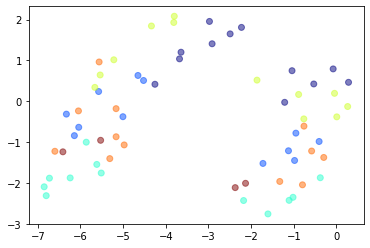

In [ ]:
def save_tsne_visualization(net, dataloader):
    fig = plt.figure()

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    print('train on ', device)

    net = net.to(device)
    net.eval()

    x, y = [], []
    for videos, labels in dataloader:
        videos = videos.to(device)
        _, features = net(videos)
        print(features.shape)
        features = nn.functional.normalize(features.mean(dim=[2, 3]))
        print(features.shape)
        x.append(features.cpu().detach().numpy())
        y.append(labels.numpy())
        break

    x = np.concatenate(x)
    y = np.concatenate(y)
    
    tsne =TSNE(n_components=2, init='random', learning_rate='auto', ) 
    vec = tsne.fit_transform(x)
    
    plt.scatter(vec[:,0], vec[:,1], c=y, cmap='jet', alpha=0.5)
    plt.show()    

if __name__ == '__main__':
    torch.manual_seed(1234)
    np.random.seed(1234)
    random.seed(1234)
    
    model_path = 'skeleton.pth'
    net = load_trained_net(model_path)

    batch_size = 64
    
    dataloader = make_dataloader()
    
    save_tsne_visualization(net, dataloader['val'])


In [ ]:
a = make_dataloader()

train size  196
val size  84
